# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.discrete, source=Source.all, past=Past.last_bin, durl=Durl.exclude_past, max_distance=1)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 5600 substitutions for model Model(time=Time.discrete, source=Source.all, past=Past.last_bin, durl=Durl.exclude_past, max_distance=1)


  0% (   1 of 5600) |                      | Elapsed Time: 0:00:03 ETA:  6:09:14

  1% (  70 of 5600) |                      | Elapsed Time: 0:00:04 ETA:  0:01:00

  2% ( 125 of 5600) |                      | Elapsed Time: 0:00:05 ETA:  0:01:23

  2% ( 140 of 5600) |                      | Elapsed Time: 0:00:06 ETA:  0:01:23

  3% ( 210 of 5600) |                      | Elapsed Time: 0:00:07 ETA:  0:01:20

  5% ( 280 of 5600) |#                     | Elapsed Time: 0:00:08 ETA:  0:01:16

  6% ( 350 of 5600) |#                     | Elapsed Time: 0:00:08 ETA:  0:01:11

  7% ( 420 of 5600) |#                     | Elapsed Time: 0:00:09 ETA:  0:01:08

  8% ( 490 of 5600) |#                     | Elapsed Time: 0:00:10 ETA:  0:01:10

 10% ( 560 of 5600) |##                    | Elapsed Time: 0:00:11 ETA:  0:01:02

 11% ( 630 of 5600) |##                    | Elapsed Time: 0:00:12 ETA:  0:01:00

 12% ( 700 of 5600) |##                    | Elapsed Time: 0:00:13 ETA:  0:00:57

 13% ( 770 of 5600) |###                   | Elapsed Time: 0:00:14 ETA:  0:00:56

 15% ( 840 of 5600) |###                   | Elapsed Time: 0:00:15 ETA:  0:00:55

 16% ( 910 of 5600) |###                   | Elapsed Time: 0:00:16 ETA:  0:00:56

 17% ( 980 of 5600) |###                   | Elapsed Time: 0:00:17 ETA:  0:00:56

 18% (1050 of 5600) |####                  | Elapsed Time: 0:00:18 ETA:  0:00:55

 20% (1120 of 5600) |####                  | Elapsed Time: 0:00:19 ETA:  0:00:55

 21% (1190 of 5600) |####                  | Elapsed Time: 0:00:19 ETA:  0:00:54

 22% (1260 of 5600) |####                  | Elapsed Time: 0:00:20 ETA:  0:00:52

 23% (1330 of 5600) |#####                 | Elapsed Time: 0:00:21 ETA:  0:00:51

 25% (1400 of 5600) |#####                 | Elapsed Time: 0:00:22 ETA:  0:00:50

 26% (1470 of 5600) |#####                 | Elapsed Time: 0:00:23 ETA:  0:00:50

 27% (1540 of 5600) |######                | Elapsed Time: 0:00:24 ETA:  0:00:48

 28% (1588 of 5600) |######                | Elapsed Time: 0:00:25 ETA:  0:00:50

 28% (1610 of 5600) |######                | Elapsed Time: 0:00:25 ETA:  0:00:50

 30% (1680 of 5600) |######                | Elapsed Time: 0:00:26 ETA:  0:00:51

 31% (1750 of 5600) |######                | Elapsed Time: 0:00:27 ETA:  0:00:52

 32% (1820 of 5600) |#######               | Elapsed Time: 0:00:28 ETA:  0:00:53

 33% (1890 of 5600) |#######               | Elapsed Time: 0:00:29 ETA:  0:00:52

 35% (1960 of 5600) |#######               | Elapsed Time: 0:00:30 ETA:  0:00:49

 36% (2030 of 5600) |#######               | Elapsed Time: 0:00:31 ETA:  0:00:47

 37% (2100 of 5600) |########              | Elapsed Time: 0:00:32 ETA:  0:00:42

 38% (2170 of 5600) |########              | Elapsed Time: 0:00:33 ETA:  0:00:40

 40% (2240 of 5600) |########              | Elapsed Time: 0:00:33 ETA:  0:00:36

 41% (2310 of 5600) |#########             | Elapsed Time: 0:00:34 ETA:  0:00:36

 42% (2380 of 5600) |#########             | Elapsed Time: 0:00:35 ETA:  0:00:34

 43% (2450 of 5600) |#########             | Elapsed Time: 0:00:36 ETA:  0:00:33

 45% (2520 of 5600) |#########             | Elapsed Time: 0:00:37 ETA:  0:00:31

 46% (2590 of 5600) |##########            | Elapsed Time: 0:00:38 ETA:  0:00:34

 47% (2660 of 5600) |##########            | Elapsed Time: 0:00:39 ETA:  0:00:31

 48% (2730 of 5600) |##########            | Elapsed Time: 0:00:40 ETA:  0:00:31

 50% (2800 of 5600) |###########           | Elapsed Time: 0:00:41 ETA:  0:00:31

 51% (2870 of 5600) |###########           | Elapsed Time: 0:00:42 ETA:  0:00:30

 52% (2940 of 5600) |###########           | Elapsed Time: 0:00:42 ETA:  0:00:29

 53% (3010 of 5600) |###########           | Elapsed Time: 0:00:43 ETA:  0:00:26

 55% (3080 of 5600) |############          | Elapsed Time: 0:00:44 ETA:  0:00:26

 56% (3150 of 5600) |############          | Elapsed Time: 0:00:45 ETA:  0:00:22

 57% (3220 of 5600) |############          | Elapsed Time: 0:00:46 ETA:  0:00:21

 58% (3272 of 5600) |############          | Elapsed Time: 0:00:47 ETA:  0:00:25

 58% (3290 of 5600) |############          | Elapsed Time: 0:00:47 ETA:  0:00:25

 60% (3360 of 5600) |#############         | Elapsed Time: 0:00:48 ETA:  0:00:23

 61% (3430 of 5600) |#############         | Elapsed Time: 0:00:49 ETA:  0:00:23

 62% (3500 of 5600) |#############         | Elapsed Time: 0:00:50 ETA:  0:00:23

 63% (3570 of 5600) |##############        | Elapsed Time: 0:00:51 ETA:  0:00:23

 65% (3640 of 5600) |##############        | Elapsed Time: 0:00:52 ETA:  0:00:22

 66% (3710 of 5600) |##############        | Elapsed Time: 0:00:52 ETA:  0:00:20

 67% (3780 of 5600) |##############        | Elapsed Time: 0:00:53 ETA:  0:00:20

 68% (3850 of 5600) |###############       | Elapsed Time: 0:00:54 ETA:  0:00:15

 70% (3920 of 5600) |###############       | Elapsed Time: 0:00:55 ETA:  0:00:13

 71% (3990 of 5600) |###############       | Elapsed Time: 0:00:56 ETA:  0:00:13

 72% (4060 of 5600) |###############       | Elapsed Time: 0:00:57 ETA:  0:00:11

 73% (4130 of 5600) |################      | Elapsed Time: 0:00:58 ETA:  0:00:10

 75% (4200 of 5600) |################      | Elapsed Time: 0:00:59 ETA:  0:00:10

 76% (4270 of 5600) |################      | Elapsed Time: 0:00:59 ETA:  0:00:10

 77% (4340 of 5600) |#################     | Elapsed Time: 0:01:00 ETA:  0:00:09

 78% (4410 of 5600) |#################     | Elapsed Time: 0:01:01 ETA:  0:00:10

 80% (4480 of 5600) |#################     | Elapsed Time: 0:01:03 ETA:  0:00:14

 81% (4550 of 5600) |#################     | Elapsed Time: 0:01:03 ETA:  0:00:13

 82% (4620 of 5600) |##################    | Elapsed Time: 0:01:04 ETA:  0:00:12

 83% (4690 of 5600) |##################    | Elapsed Time: 0:01:05 ETA:  0:00:10

 85% (4760 of 5600) |##################    | Elapsed Time: 0:01:06 ETA:  0:00:09

 86% (4830 of 5600) |##################    | Elapsed Time: 0:01:07 ETA:  0:00:09

 87% (4900 of 5600) |###################   | Elapsed Time: 0:01:08 ETA:  0:00:07

 88% (4970 of 5600) |###################   | Elapsed Time: 0:01:09 ETA:  0:00:05

 90% (5040 of 5600) |###################   | Elapsed Time: 0:01:10 ETA:  0:00:02

 91% (5110 of 5600) |####################  | Elapsed Time: 0:01:11 ETA:  0:00:01

 92% (5180 of 5600) |####################  | Elapsed Time: 0:01:12 ETA:  0:00:00

 93% (5250 of 5600) |####################  | Elapsed Time: 0:01:13 ETA:  0:00:00

 94% (5300 of 5600) |####################  | Elapsed Time: 0:01:14 ETA:  0:00:03

 95% (5320 of 5600) |####################  | Elapsed Time: 0:01:14 ETA:  0:00:03

 96% (5390 of 5600) |##################### | Elapsed Time: 0:01:15 ETA:  0:00:01

 97% (5460 of 5600) |##################### | Elapsed Time: 0:01:16 ETA:  0:00:02

 98% (5530 of 5600) |##################### | Elapsed Time: 0:01:17 ETA:  0:00:02

100% (5600 of 5600) |######################| Elapsed Time: 0:01:18 Time: 0:01:18


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

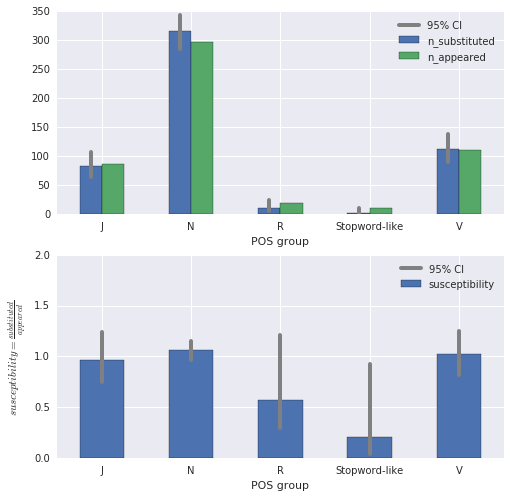

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

------
degree
------
     Target NOT different from H_0 (p > 0.05)

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)

--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]


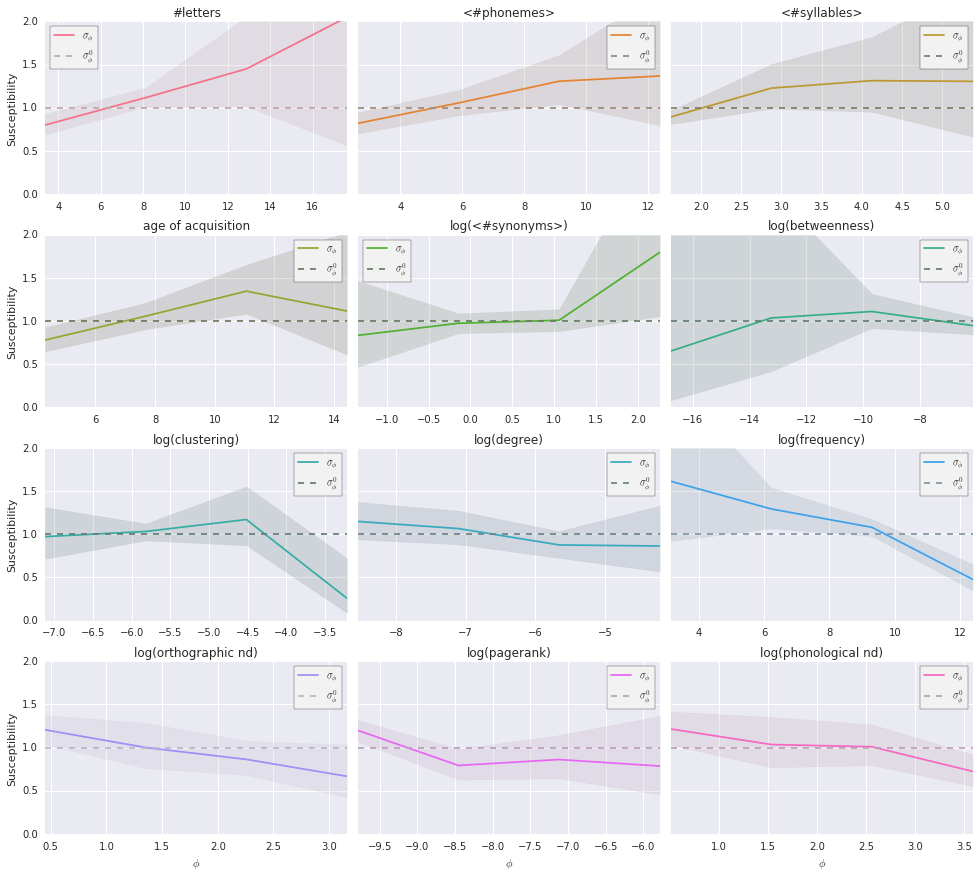

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of regio


--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)


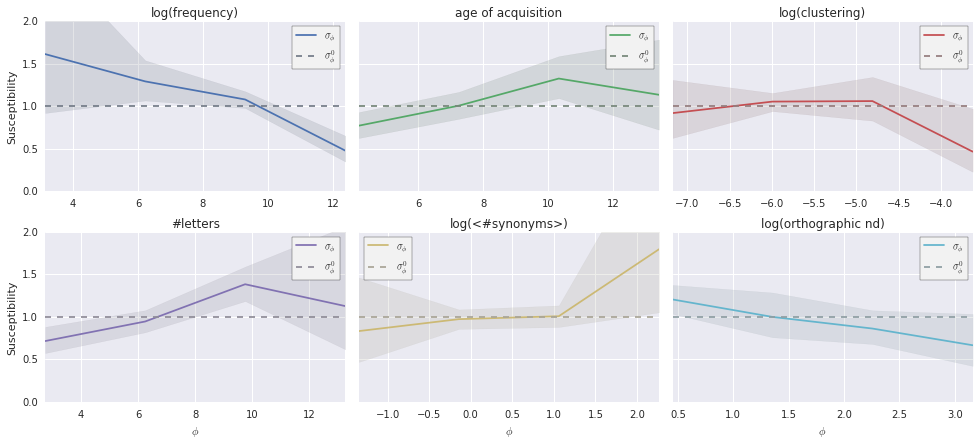

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
     Target NOT different from H_0 (p > 0.05)

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)

--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
     Target NOT different from H_0 (p > 0.01)

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)


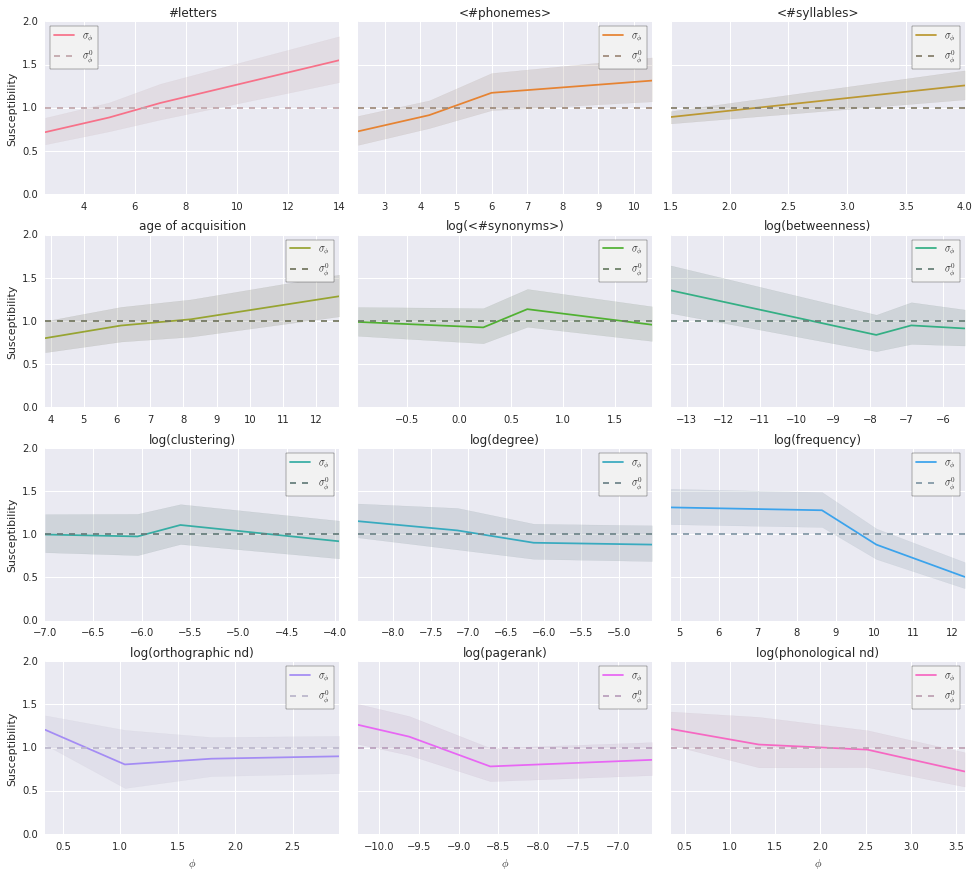

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)


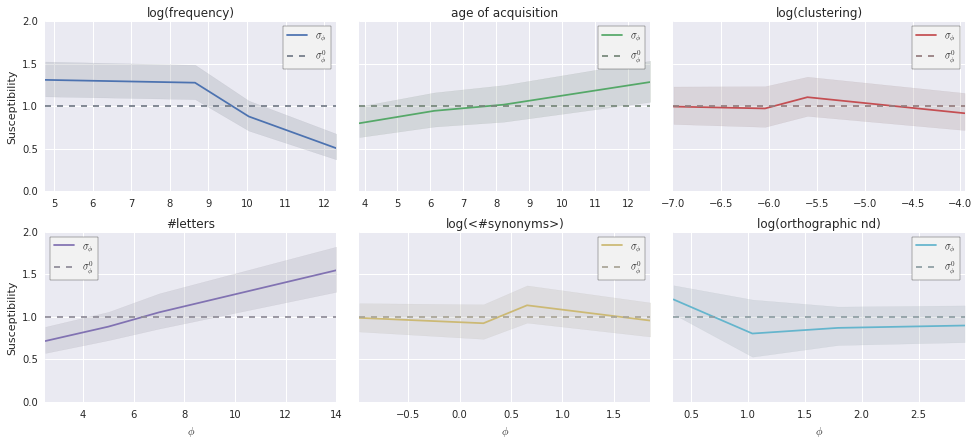

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.001)

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)


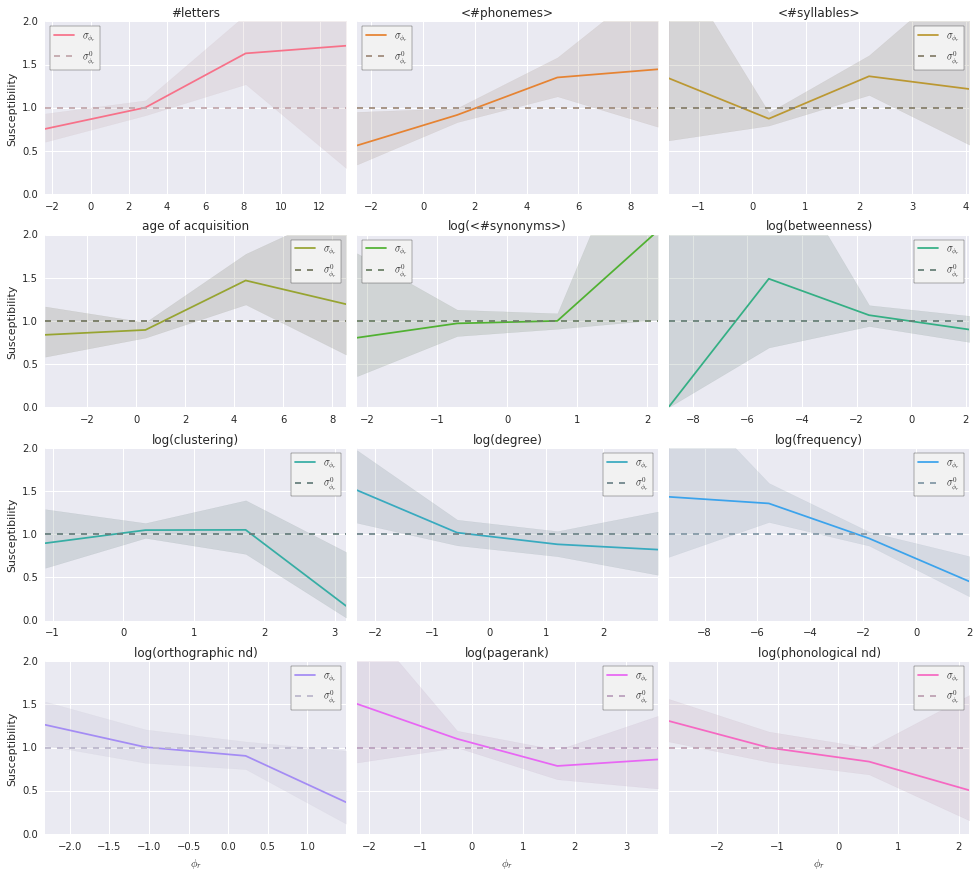

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]

----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]


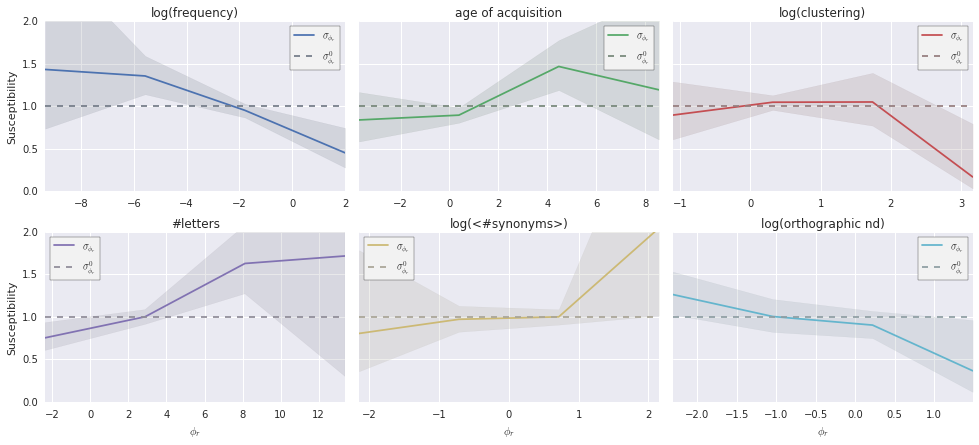

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)

--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)


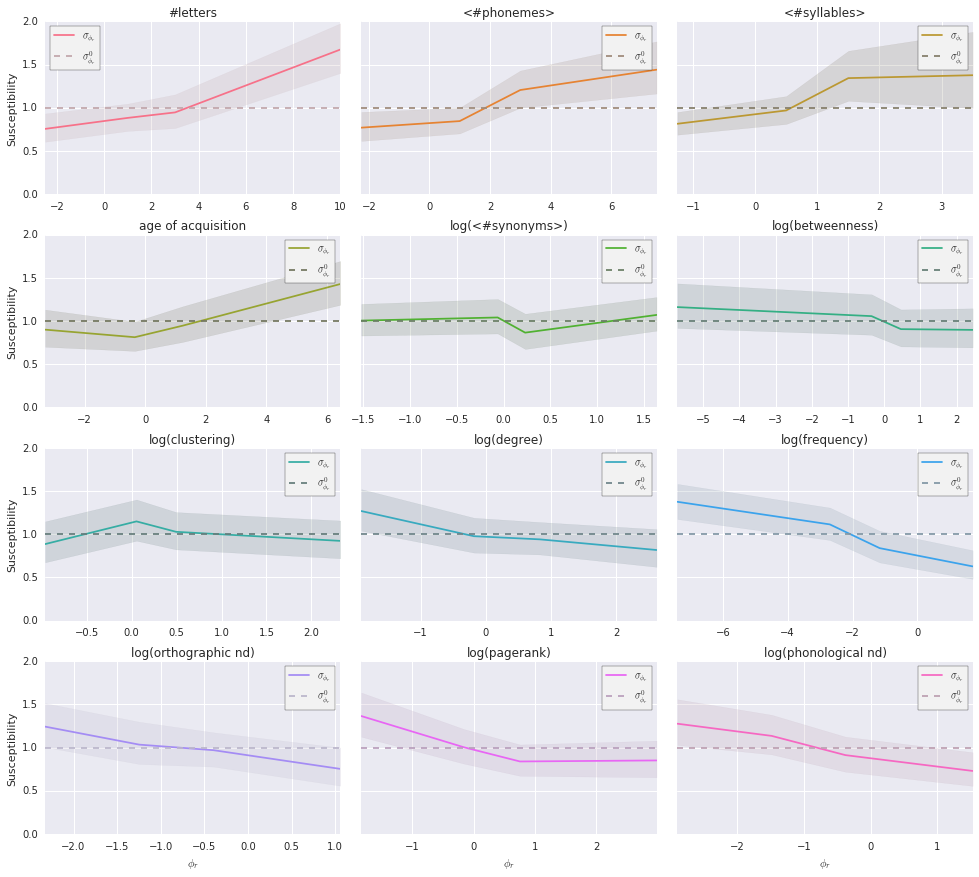

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)


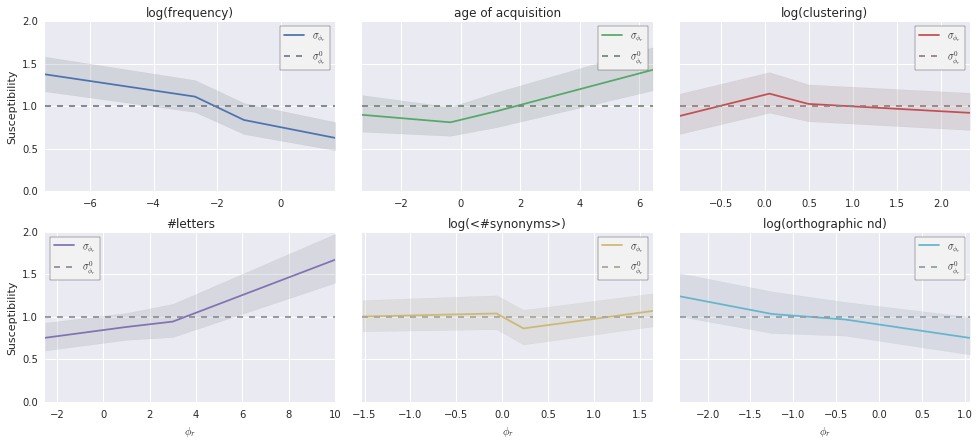

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)

--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


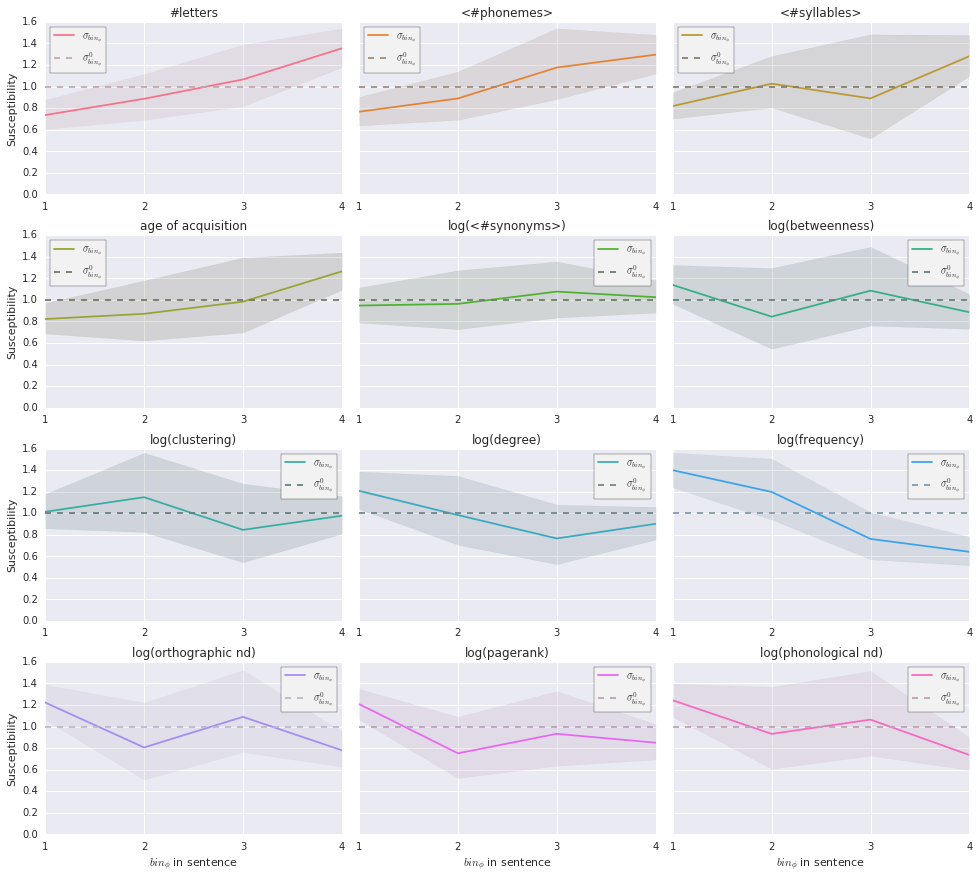

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)


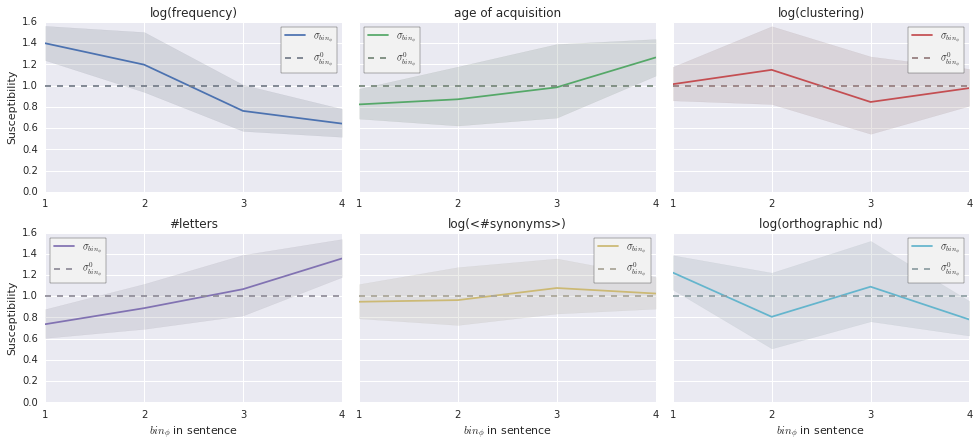

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)

--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]


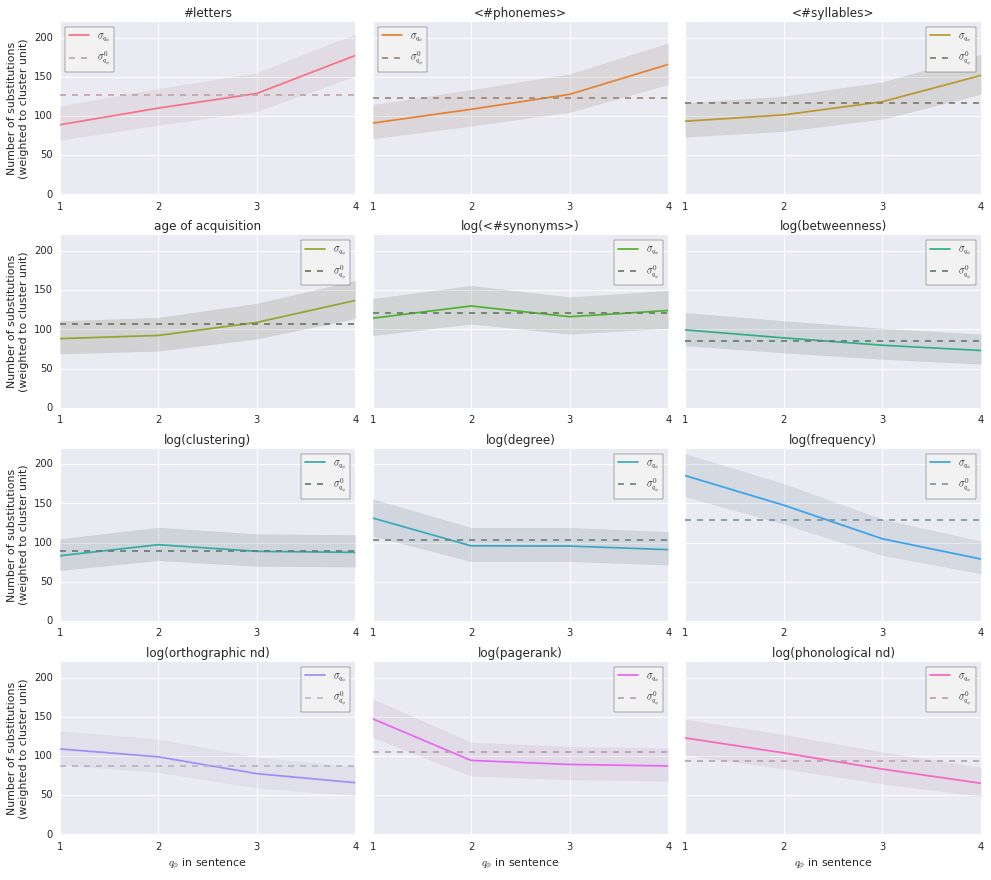

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)


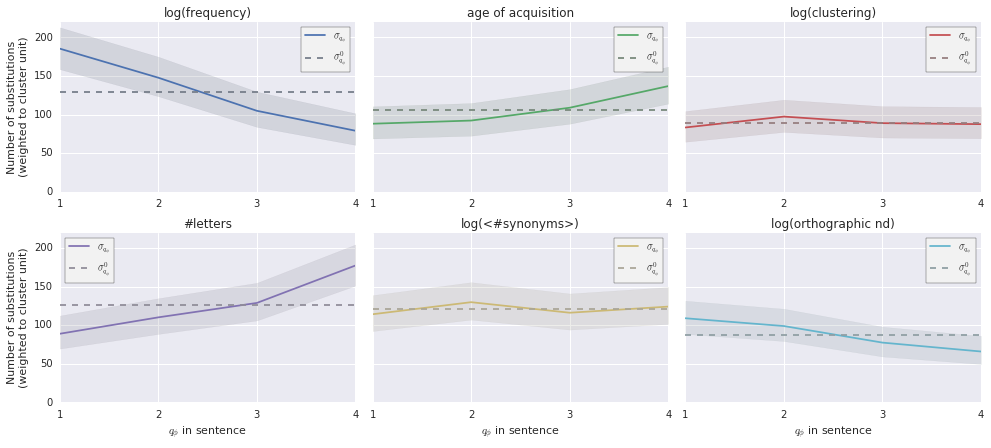

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 13127 word measures (divided into training and prediction sets)

46.56% of words well predicted (non-random at p = 3e-08)
Precision = 0.22
Recall = 0.47

Coefficients:
intercept                                             2.632620
global_frequency                                     -0.393767
global_aoa                                           -0.250513
global_letters_count                                  0.274200
global_orthographic_density                          -0.374493
global_frequency * global_aoa                         0.034933
global_frequency * global_letters_count              -0.014343
global_frequency * global_orthographic_density        0.085481
global_aoa * global_letters_count                    -0.008627
global_aoa * global_orthographic_density              0.019940
global_letters_count * global_orthographic_density   -0.100600
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 13127 word measures (divided into training and prediction sets)

56.28% of words well predicted (non-random at p = 3e-24)
Precision = 0.27
Recall = 0.47

Coefficients:
intercept                                                        -0.363443
sentence-rel_frequency                                           -0.076254
sentence-rel_aoa                                                 -0.226753
sentence-rel_letters_count                                        0.051385
sentence-rel_orthographic_density                                 0.207819
sentence-rel_frequency * sentence-rel_aoa                        -0.059092
sentence-rel_frequency * sentence-rel_letters_count               0.026392
sentence-rel_frequency * sentence-rel_orthographic_density        0.079188
sentence-rel_aoa * sentence-rel_letters_count                     0.036460
sentence-rel_aoa * sentence-rel_orthographic_density              0.031332
sentence-rel_letters_count * sentence-rel_orthographic_density   -

**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 13127 word measures (divided into training and prediction sets)



61.37% of words well predicted (non-random at p = 3e-76)
Precision = 0.30
Recall = 0.46

Coefficients:
intercept                                                          0.845996
sentence-rel_frequency                                            -0.718251
sentence-rel_aoa                                                  -0.356079
sentence-rel_letters_count                                        -0.354167
sentence-rel_orthographic_density                                 -0.156533
global_frequency                                                   0.395454
global_aoa                                                        -2.653085
global_letters_count                                               1.726442
global_orthographic_density                                        0.694904
sentence-rel_frequency * sentence-rel_aoa                         -0.117990
sentence-rel_frequency * sentence-rel_letters_count               -0.141471
sentence-rel_frequency * sentence-rel_orthographic_density  

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 13127 word measures (divided into training and prediction sets)

51.28% of words well predicted (non-random at p = 0.04)
Precision = 0.19
Recall = 0.32

Coefficients:
intercept                                                      -1.096920
bins-global_frequency                                          -0.517014
bins-global_aoa                                                 1.897328
bins-global_letters_count                                      -0.998477
bins-global_orthographic_density                               -0.989174
bins-global_frequency * bins-global_aoa                        -0.803769
bins-global_frequency * bins-global_letters_count               1.356700
bins-global_frequency * bins-global_orthographic_density       -0.582646
bins-global_aoa * bins-global_letters_count                    -0.507093
bins-global_aoa * bins-global_orthographic_density              0.886885
bins-global_letters_count * bins-global_orthographic_density    0.260009
dtype: float64

**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 13127 word measures (divided into training and prediction sets)

63.74% of words well predicted (non-random at p = 4e-111)
Precision = 0.36
Recall = 0.67

Coefficients:
intercept                                                                 0.700419
quantiles-global_frequency                                                0.339432
quantiles-global_aoa                                                     -0.126253
quantiles-global_letters_count                                            0.181043
quantiles-global_orthographic_density                                    -1.567378
quantiles-global_frequency * quantiles-global_aoa                        -0.306491
quantiles-global_frequency * quantiles-global_letters_count              -0.113950
quantiles-global_frequency * quantiles-global_orthographic_density        0.094750
quantiles-global_aoa * quantiles-global_letters_count                     0.145502
quantiles-global_aoa * quantiles-global_orthographic_density        

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 13127 word measures (divided into training and prediction sets)

65.07% of words well predicted (non-random at p = 2e-133)
Precision = 0.22
Recall = 0.18

Coefficients:
intercept                                                                   0.117105
bins-sentence-rel_frequency                                                 0.088422
bins-sentence-rel_aoa                                                       0.328336
bins-sentence-rel_letters_count                                            -0.444869
bins-sentence-rel_orthographic_density                                      0.117105
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.946154
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.393943
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density        0.088422
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.331527
bins-sentence-rel_aoa * bins-sentence-rel_orthogra

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 13127 word measures (divided into training and prediction sets)

45.17% of words well predicted (non-random at p = 5e-15)
Precision = 0.24
Recall = 0.60

Coefficients:
intercept                                                                             3.015310
quantiles-sentence-rel_frequency                                                     -1.769539
quantiles-sentence-rel_aoa                                                           -1.077181
quantiles-sentence-rel_letters_count                                                 -1.062599
quantiles-sentence-rel_orthographic_density                                          -1.506585
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.251539
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count               0.101535
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        1.063292
quantiles-sentence-rel_aoa * quantiles-sentence-rel_lett

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 13127 word measures (divided into training and prediction sets)

53.38% of words well predicted (non-random at p = 5e-08)
Precision = 0.21
Recall = 0.35

Coefficients:
intercept                                                                -0.291951
in-sentence-bins_frequency                                                0.176417
in-sentence-bins_aoa                                                      0.113760
in-sentence-bins_letters_count                                            0.165660
in-sentence-bins_orthographic_density                                     0.102876
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.066635
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.201498
in-sentence-bins_frequency * in-sentence-bins_orthographic_density       -0.069973
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.045468
in-sentence-bins_aoa * in-sentence-bins_orthographic_density         

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 418 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.66531282  0.20265043]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.303804  0.482867
aoa            0.728038 -0.438390
letters_count  0.614544  0.758060


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 418 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.61960885  0.22685653]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.422664  0.433781
aoa            0.692011 -0.412486
letters_count  0.585215  0.801055
